## 📋 Brief Report

---

### 1. Overall Approach

We built a **hybrid grammar‑scoring engine** that combines:

1. **Hand‑crafted NLP features**

   * Grammar error counts
   * Syntactic complexity metrics
   * GEC (Grammar Error Correction) edit rates

2. **Classical ML ensemble**

   * RandomForest, LightGBM, Ridge trained on the above features

3. **Deep learning**

   * DistilBERT fine‑tuned for regression on cleaned transcripts

4. **Meta‑stacking**

   * Final Ridge regressor blending the feature‑ensemble and BERT predictions

> This design leverages explicit linguistic signals alongside powerful contextual embeddings to approximate expert human scoring.

---

### 2. Preprocessing Steps

| Step                       | Description                                                                                                         |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **Audio cleanup**          | Resample to 16 kHz, normalize amplitude, trim silence via `librosa`.                                                |
| **ASR transcription**      | Use OpenAI Whisper‑base to convert audio → raw transcript.                                                          |
| **Transcript cleaning**    | Lowercase, remove fillers (e.g. “um”, “uh”), fix spacing & punctuation.                                             |
| **NLP feature extraction** | • Grammar errors via LanguageTool<br>• Avg. sentence length & POS diversity via spaCy<br>• Word‑count normalization |
| **GEC features**           | • T5‑based grammar correction<br>• Levenshtein edit distance & edit‑rate per word                                   |

---

### 3. Pipeline Architecture

```text
Raw Audio
   ↓ Audio Cleanup (resample, normalize, trim)
   ↓ Whisper ASR
Raw Transcripts
   ↓ Transcript Cleaning (remove fillers, punctuation)
   ↓─── Parallel Branch ───────────────────────────────┐
   │                                                  │
   │  Hand‑crafted NLP & GEC features → Classical ML →│ feature_pred
   │                                                  │
   └─> DistilBERT regression on cleaned text → bert_pred
      (fine‑tuned with warmup, weight‑decay, fp16,
       best‑model checkpointing on Pearson)
   ↓
Stack [feature_pred, bert_pred]
   ↓
Meta‑regressor (Ridge) → Final Grammar Score (0–5)

```


In [5]:
# Import necessary libraries
from IPython import get_ipython
from IPython.display import display

# Install required packages
# !pip install librosa soundfile torchaudio transformers pytorch-lightning

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Configure Kaggle API to download dataset
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c shl-hiring-assessment
!unzip \*.zip -d data/

Archive:  shl-hiring-assessment.zip
  inflating: data/Dataset/audios/test/audio_1001.wav  
  inflating: data/Dataset/audios/test/audio_1006.wav  
  inflating: data/Dataset/audios/test/audio_1011.wav  
  inflating: data/Dataset/audios/test/audio_1025.wav  
  inflating: data/Dataset/audios/test/audio_1028.wav  
  inflating: data/Dataset/audios/test/audio_1039.wav  
  inflating: data/Dataset/audios/test/audio_1041.wav  
  inflating: data/Dataset/audios/test/audio_1046.wav  
  inflating: data/Dataset/audios/test/audio_1055.wav  
  inflating: data/Dataset/audios/test/audio_1059.wav  
  inflating: data/Dataset/audios/test/audio_1069.wav  
  inflating: data/Dataset/audios/test/audio_1079.wav  
  inflating: data/Dataset/audios/test/audio_108.wav  
  inflating: data/Dataset/audios/test/audio_1088.wav  
  inflating: data/Dataset/audios/test/audio_1090.wav  
  inflating: data/Dataset/audios/test/audio_1092.wav  
  inflating: data/Dataset/audios/test/audio_1099.wav  
  inflating: data/Dataset/audi

In [3]:
# Extract the downloaded zip file
import zipfile

with zipfile.ZipFile('/content/shl-hiring-assessment.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

In [4]:
# Read train and test CSVs into pandas DataFrames
import pandas as pd

train_df = pd.read_csv("/content/extracted_data/Dataset/train.csv")
test_df  = pd.read_csv("/content/extracted_data/Dataset/test.csv")
#sub_df   = pd.read_csv("/content/extracted_data/Dataset/sample_submission.csv")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
train_df.head()

Train shape: (444, 2)
Test  shape: (204, 1)


,filename,label
0,audio_710.wav,1.0
1,audio_1265.wav,1.0
2,audio_1114.wav,1.5
3,audio_946.wav,1.5
4,audio_1127.wav,2.0


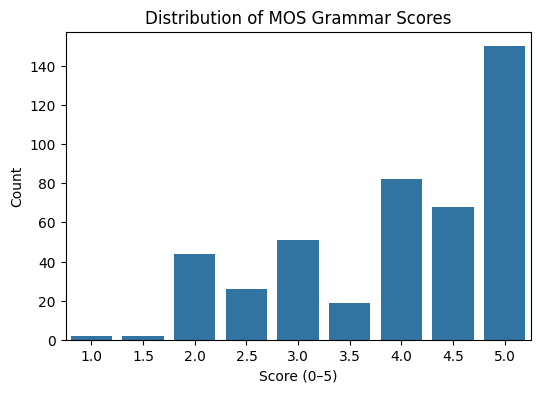

In [ ]:
# Exploratory Data Analysis (EDA): Visualize score distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=train_df)
plt.title("Distribution of MOS Grammar Scores")
plt.xlabel("Score (0–5)")
plt.ylabel("Count")
plt.show()

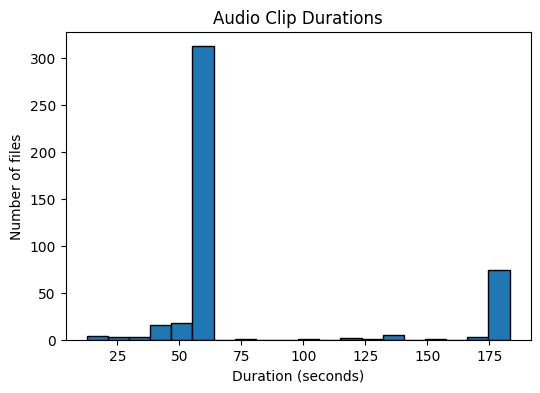

In [ ]:
# EDA: Visualize audio clip durations
import soundfile as sf

# Helper to read duration
def get_duration(sec_file):
    data, sr = sf.read(f"/content/extracted_data/Dataset/audios/train/{sec_file}")
    return len(data) / sr

# Compute durations
train_df["duration_s"] = train_df["filename"].apply(get_duration)

plt.figure(figsize=(6,4))
plt.hist(train_df["duration_s"], bins=20, edgecolor='k')
plt.title("Audio Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.show()

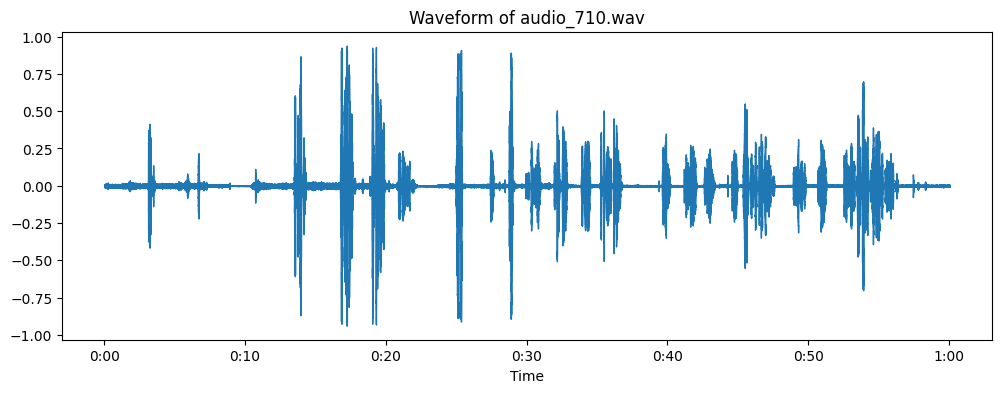

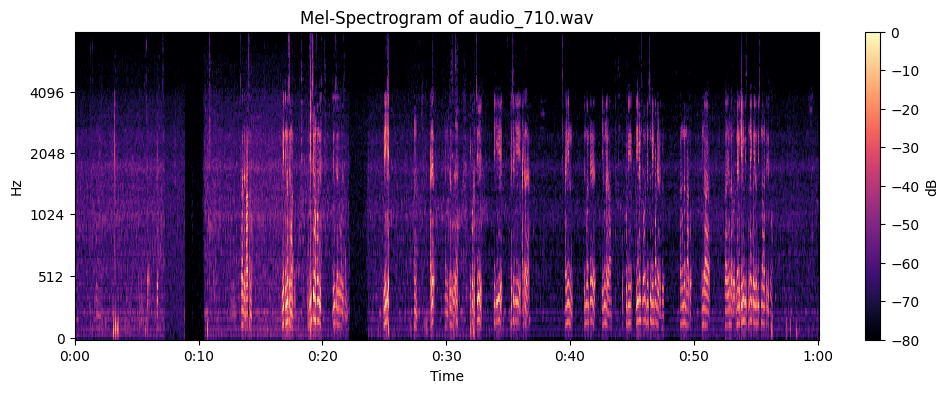

In [ ]:
# EDA: Display waveform and spectrogram of an example audio file
import librosa
import librosa.display
import numpy as np

# pick any random file
example_file = train_df["filename"].iloc[0]
audio_path   = f"/content/extracted_data/Dataset/audios/train/{example_file}"

y, sr = librosa.load(audio_path, sr=16000)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {example_file}")
plt.show()

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   n_fft=1024, hop_length=512)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=512,
                         x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title(f"Mel-Spectrogram of {example_file}")
plt.show()

In [6]:
# 1. AUDIO PREPROCESSING: Resample, normalize, and trim audio files

# Install dependencies if needed
# !pip install -q librosa soundfile

import os
import librosa
import soundfile as sf
from tqdm import tqdm


RAW_TRAIN_DIR = "/content/extracted_data/Dataset/audios/train"
RAW_TEST_DIR  = "/content/extracted_data/Dataset/audios/test"
PROC_TRAIN_DIR = "/content/processed_audio/train"
PROC_TEST_DIR  = "/content/processed_audio/test"

# Create output directories
os.makedirs(PROC_TRAIN_DIR, exist_ok=True)
os.makedirs(PROC_TEST_DIR, exist_ok=True)

def preprocess_audio(in_path, out_path, target_sr=16000, top_db=25):
    #load
    y, sr = librosa.load(in_path, sr=None)
    #resample if needed
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    #normalize to [-1,1]
    y = y / max(1e-8, max(abs(y)))
    #trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=top_db)
    #write out
    sf.write(out_path, y, target_sr)

# Process train set
for fname in tqdm(train_df['filename'].tolist(), desc="Preprocessing train"):
    src = os.path.join(RAW_TRAIN_DIR, fname)
    dst = os.path.join(PROC_TRAIN_DIR, fname)
    preprocess_audio(src, dst)

# Process test set
for fname in tqdm(test_df['filename'].tolist(), desc="Preprocessing test"):
    src = os.path.join(RAW_TEST_DIR, fname)
    dst = os.path.join(PROC_TEST_DIR, fname)
    preprocess_audio(src, dst)



Preprocessing test: 100%|██████████| 204/204 [00:22<00:00,  9.11it/s]


In [ ]:
# 2. ASR TRANSCRIPTION: Transcribe audio using Whisper

# Install Whisper if needed
# !pip install git+https://github.com/openai/whisper.git

import whisper
from tqdm import tqdm

# load Whisper model once
asr_model = whisper.load_model("base")

def transcribe_file(path):
    # returns the raw transcript string
    res = asr_model.transcribe(path, language="en", verbose=False)
    return res["text"].strip()

# Transcribe train
train_transcripts = []
for fname in tqdm(train_df['filename'], desc="ASR train"):
    wav = os.path.join(PROC_TRAIN_DIR, fname)
    train_transcripts.append(transcribe_file(wav))
train_df['transcript'] = train_transcripts

# Transcribe test
test_transcripts = []
for fname in tqdm(test_df['filename'], desc="ASR test"):
    wav = os.path.join(PROC_TEST_DIR, fname)
    test_transcripts.append(transcribe_file(wav))
test_df['transcript'] = test_transcripts

# Save output
train_df.to_csv("train_with_transcripts.csv", index=False)
test_df .to_csv("test_with_transcripts.csv", index=False)



In [7]:
# 3. TRANSCRIPT CLEANING: Remove fillers and extra whitespace

# Install required NLP packages
# !pip install -q language_tool_python spacy
# !python -m spacy download en_core_web_sm

import re
import pandas as pd

# reload data with raw transcripts
train_df = pd.read_csv("train_with_transcripts.csv")
test_df  = pd.read_csv("test_with_transcripts.csv")

# list of common disfluencies/fillers
FILLERS = ['um','uh','like','you know','i mean','so','actually','basically','right','okay']

def clean_transcript(text):
    # Check if text is a string before applying lower()
    if isinstance(text, str):
        # lowercase
        t = text.lower()
        # remove fillers as whole words
        pattern = r'\b(?:' + '|'.join(re.escape(f) for f in FILLERS) + r')\b'
        t = re.sub(pattern, '', t)
        # remove extra whitespace
        t = re.sub(r'\s+', ' ', t).strip()
        # fix space before punctuation
        t = re.sub(r'\s+([?.!,"])', r'\1', t)
        return t
    else:
        # Handle non-string values, e.g., by returning an empty string or NaN
        return ""  # or return float('nan')

# apply cleaning
train_df['cleaned'] = train_df['transcript'].map(clean_transcript)
test_df ['cleaned'] = test_df ['transcript'].map(clean_transcript)

# save cleaned
train_df.to_csv("train_cleaned.csv", index=False)
test_df .to_csv("test_cleaned.csv", index=False)

In [8]:
import os
# Install Java 17
!apt-get install -y openjdk-17-jdk-headless

# Set JAVA_HOME environment variable
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'

# Update language_tool_python
!pip install --upgrade language_tool_python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 120 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.14+7-1~22.04.1 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.14+7-1~22.04.1 [71.3 MB]
Fetched 120 MB in 3s (40.5 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ...

In [9]:
# 4. GRAMMAR & NLP FEATURE EXTRACTION
# ─────────────────────────────────────

import language_tool_python
import spacy
import numpy as np

# load tools
tool = language_tool_python.LanguageTool('en-US')
nlp  = spacy.load("en_core_web_sm")

def extract_nlp_features(text):
    # grammar error count
    errors = tool.check(text)
    grammar_errors = len(errors)
    # syntactic complexity
    doc = nlp(text)
    # sentence lengths (# tokens)
    sent_lens = [len(sent) for sent in doc.sents] or [0]
    avg_sent_len = np.mean(sent_lens)
    # POS diversity: number of unique POS tags
    pos_tags = [token.pos_ for token in doc if not token.is_space]
    pos_diversity = len(set(pos_tags))
    # word count
    word_count = len([t for t in doc if not t.is_space])
    return grammar_errors, avg_sent_len, pos_diversity, word_count

# apply to train
features = train_df['cleaned'].map(extract_nlp_features)
train_df[['grammar_errors','avg_sent_len','pos_diversity','word_count']] = \
    pd.DataFrame(features.tolist(), index=train_df.index)

# apply to test
features = test_df['cleaned'].map(extract_nlp_features)
test_df[['grammar_errors','avg_sent_len','pos_diversity','word_count']] = \
    pd.DataFrame(features.tolist(), index=test_df.index)

# quick check by printing
print(train_df[['cleaned','grammar_errors','avg_sent_len','pos_diversity','word_count']].head())

# save intermediate features
train_df.to_csv("train_features.csv", index=False)
test_df .to_csv("test_features.csv", index=False)


INFO:language_tool_python.download_lt:Unzipping /tmp/tmp30l57c6u.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip to /root/.cache/language_tool_python.


                                             cleaned  grammar_errors  \
0  for instance dune 17 is 17 qi as he got hit by...              11   
1  my favorite hobby is cultivation of plants suc...               3   
2  my goal is to become an electrical employee an...               3   
3  the playground looks very clear and neat as th...               1   
4  my goal is to bring my parents to live with me...              15   

   avg_sent_len  pos_diversity  word_count  
0     11.250000             12          90  
1     16.500000             10          33  
2     47.000000             11          47  
3     20.000000             10          20  
4     12.090909             12         133  


In [10]:
# 5. Feature Enhancement

# compute errors per word and any other normalized metrics
train_df['errors_per_word'] = train_df['grammar_errors'] / train_df['word_count'].replace(0,1)
test_df ['errors_per_word'] = test_df ['grammar_errors'] / test_df ['word_count'].replace(0,1)

# one might also add squared or interaction terms if desired
train_df['sentlen_x_errors'] = train_df['avg_sent_len'] * train_df['grammar_errors']
test_df ['sentlen_x_errors'] = test_df ['avg_sent_len'] * test_df ['grammar_errors']

# final feature list
FEATURE_COLS = [
    'grammar_errors','avg_sent_len','pos_diversity','word_count',
    'errors_per_word','sentlen_x_errors'
]


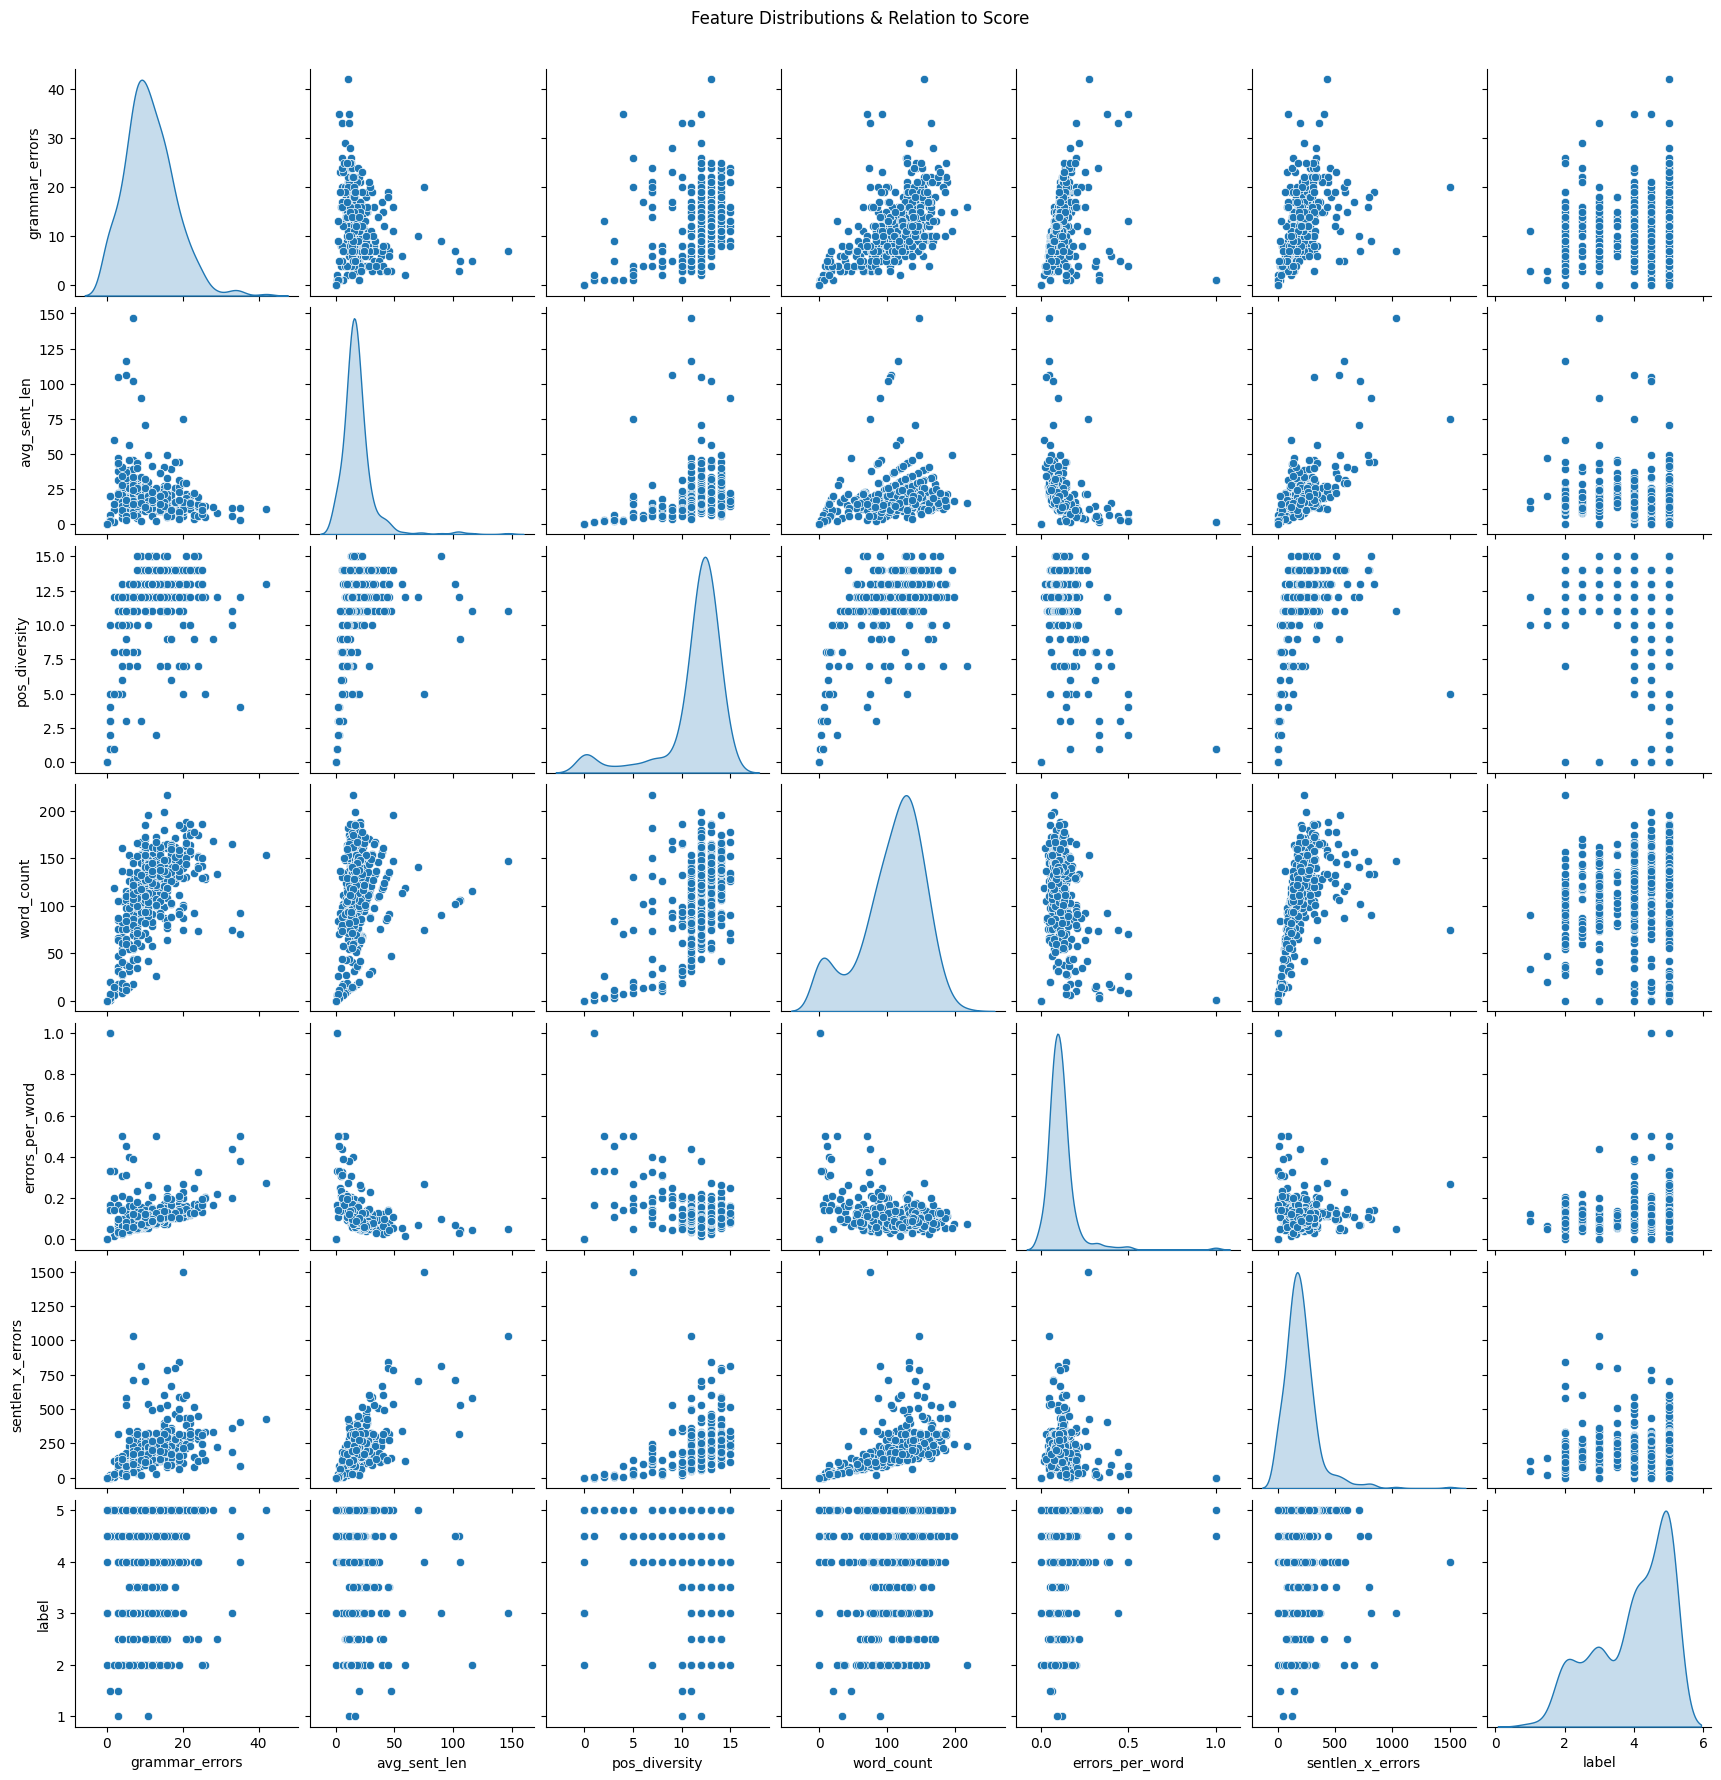

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pair plots to visualize relationships between features and the target variable ('label')
# diag_kind='kde' specifies that kernel density estimation plots should be used for the diagonal elements
sns.pairplot(train_df[FEATURE_COLS + ['label']], diag_kind='kde')
plt.suptitle("Feature Distributions & Relation to Score", y=1.02)

# save enhanced features
train_df.to_csv("train_features_enhanced.csv", index=False)
test_df .to_csv("test_features_enhanced.csv", index=False)

In [17]:
# 6. GEC Feature Extraction

# !pip install happytransformer
# !pip install python-Levenshtein

import pandas as pd
from happytransformer import HappyTextToText, TTSettings
import Levenshtein as Lev

# load cleaned transcripts and existing features
train_df = pd.read_csv("train_cleaned.csv")
test_df  = pd.read_csv("test_cleaned.csv")

# initialize T5 grammar-correction
h = HappyTextToText("T5","vennify/t5-base-grammar-correction")
args = TTSettings(num_beams=5, min_length=1)

def gec_features(text):
    # Convert text to string if it's not already
    text = str(text)
    # run correction
    corr = h.generate_text("grammar: " + text, args=args).text.strip()
    # word-level Levenshtein edits
    # split on whitespace
    orig_words = text.split()
    corr_words = corr.split()
    # compute normalized edit distance
    ed = Lev.distance(" ".join(orig_words), " ".join(corr_words))
    # edit rate per word
    rate = ed / max(1, len(orig_words))
    return corr, ed, rate

# apply to train
out = train_df['cleaned'].map(gec_features)
train_df[['gec_corrected','gec_edits','gec_edit_rate']] = pd.DataFrame(out.tolist(), index=train_df.index)

# apply to test
out = test_df['cleaned'].map(gec_features)
test_df[['gec_corrected','gec_edits','gec_edit_rate']] = pd.DataFrame(out.tolist(), index=test_df.index)

# drop the corrected text column if not needed downstream
train_df.drop(columns='gec_corrected', inplace=True)
test_df .drop(columns='gec_corrected', inplace=True)

# save augmented feature files
train_df.to_csv("train_features_gec.csv", index=False)
test_df .to_csv("test_features_gec.csv", index=False)

print("GEC features added:", train_df[['gec_edits','gec_edit_rate']].head())

Device set to use cuda:0


GEC features added:    gec_edits  gec_edit_rate
0        178       2.311688
1         16       0.516129
2         38       0.808511
3          6       0.315789
4        395       3.434783


In [18]:
# 7. Feature-based modelling

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# load features
train = pd.read_csv("train_features_enhanced.csv")
gec = pd.read_csv("train_features_gec.csv")[['gec_edits','gec_edit_rate']]
train = train.join(gec)
test  = pd.read_csv("test_features_enhanced.csv")
gec_t = pd.read_csv("test_features_gec.csv")[['gec_edits','gec_edit_rate']]
test  = test.join(gec_t)

FEATURE_COLS = [
 'grammar_errors','avg_sent_len','pos_diversity','word_count',
 'errors_per_word','sentlen_x_errors',
 'gec_edits','gec_edit_rate'
]
X       = train[FEATURE_COLS].values
y       = train['label'].values
X_test  = test[FEATURE_COLS].values

oof_preds  = np.zeros(len(train))
test_preds = np.zeros(len(test))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    # classical models
    rf    = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=fold)
    ridge = Ridge(alpha=1.0, random_state=fold)

    # tuned LightGBM
    lgbm = lgb.LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=5,
        min_split_gain=0.01,
        reg_alpha=0.1,
        reg_lambda=0.1,
        verbosity=-1,
        random_state=fold
    )

    # train
    rf.fit(X_tr, y_tr)
    lgbm.fit(X_tr, y_tr)
    ridge.fit(X_tr, y_tr)

    # predict val
    p_rf    = rf.predict(X_va)
    p_lgbm  = lgbm.predict(X_va)
    p_ridge = ridge.predict(X_va)
    p_ens   = (p_rf + p_lgbm + p_ridge) / 3.0
    oof_preds[va_idx] = p_ens

    # predict test
    test_preds += (rf.predict(X_test) + lgbm.predict(X_test) + ridge.predict(X_test)) \
                  / 3.0 / kf.n_splits

    # metrics
    rmse    = np.sqrt(mean_squared_error(y_va, p_ens))
    pearson = pearsonr(y_va, p_ens)[0]
    print(f"Fold {fold} — RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

# overall OOF metrics
cv_rmse    = np.sqrt(mean_squared_error(y, oof_preds))
cv_pearson = pearsonr(y, oof_preds)[0]
print(f"CV RMSE: {cv_rmse:.4f}, CV Pearson: {cv_pearson:.4f}")

# save
train['pred_feat'] = oof_preds
test ['pred_feat'] = test_preds
train.to_csv("train_with_feat_preds.csv", index=False)
test .to_csv("test_with_feat_preds.csv", index=False)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 0 — RMSE: 1.0846, Pearson: 0.3867


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 — RMSE: 1.0203, Pearson: 0.2439


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 — RMSE: 1.0216, Pearson: 0.1566


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 — RMSE: 0.9757, Pearson: 0.3759
Fold 4 — RMSE: 0.9748, Pearson: 0.3246
CV RMSE: 1.0163, CV Pearson: 0.2847


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
# overall CV metrics
cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
cv_pearson = pearsonr(y, oof_preds)[0]
print(f"CV RMSE: {cv_rmse:.4f}, CV Pearson: {cv_pearson:.4f}")

CV RMSE: 1.0163, CV Pearson: 0.2847


In [21]:
# 8. Fine-tune DISTILBERT with 5‑fold cv


# !pip install -q transformers

import numpy as np, pandas as pd, torch
from transformers import (
    set_seed,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# reload data
train = pd.read_csv("train_with_feat_preds.csv")
test  = pd.read_csv("test_with_feat_preds.csv")
train['cleaned'] = train['cleaned'].astype(str).fillna('')
test ['cleaned'] = test ['cleaned'].astype(str).fillna('')

texts_train = train["cleaned"].tolist()
y = train["label"].values
texts_test  = test["cleaned"].tolist()

# tokenizer + encodings
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
enc_train = tokenizer(texts_train, padding=True, truncation=True, max_length=256)
enc_test  = tokenizer(texts_test,  padding=True, truncation=True, max_length=256)

class TxtDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings; self.labels = labels
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

def compute_metrics(eval_pred):
    preds, labels = eval_pred.predictions.squeeze(), eval_pred.label_ids
    rmse    = np.sqrt(mean_squared_error(labels, preds))
    pearson = pearsonr(labels, preds)[0]
    return {"rmse": rmse, "pearson": pearson}

oof_bert = np.zeros(len(train))
test_bert = np.zeros(len(test))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr_idx, va_idx) in enumerate(kf.split(texts_train)):
    print(f"\n=== Fold {fold} ===")
    ds_tr = TxtDataset({k:[v[i] for i in tr_idx] for k,v in enc_train.items()}, labels=y[tr_idx])
    ds_va = TxtDataset({k:[v[i] for i in va_idx] for k,v in enc_train.items()}, labels=y[va_idx])
    ds_te = TxtDataset(enc_test)

    # TrainingArguments with weight decay, warmup, fp16, best‑model loading
    args = TrainingArguments(
        output_dir=f"bert_fold{fold}",
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        fp16=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="pearson",
        greater_is_better=True,
        logging_steps=50,
        seed=42,
    )

    # Model init + freeze lower layers
    def model_init():
        m = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", problem_type="regression", num_labels=1
        )
        # freeze first 4 Transformer layers
        for param in m.distilbert.transformer.layer[:4].parameters():
            param.requires_grad = False
        return m

    trainer = Trainer(
        model_init    = model_init,
        args          = args,
        train_dataset = ds_tr,
        eval_dataset  = ds_va,
        tokenizer     = tokenizer,
        compute_metrics= compute_metrics
    )

    trainer.train()

    # collect OOF & test preds
    preds_va = trainer.predict(ds_va).predictions.squeeze()
    oof_bert[va_idx] = preds_va
    test_bert += trainer.predict(ds_te).predictions.squeeze() / kf.n_splits

    # fold metrics
    rmse_f = np.sqrt(mean_squared_error(y[va_idx], preds_va))
    p_f    = pearsonr(y[va_idx], preds_va)[0]
    print(f"Fold {fold} → RMSE: {rmse_f:.4f}, Pearson: {p_f:.4f}")

# overall CV
cv_rmse = np.sqrt(mean_squared_error(y, oof_bert))
cv_p    = pearsonr(y, oof_bert)[0]
print(f"\nDistilBERT CV → RMSE: {cv_rmse:.4f}, Pearson: {cv_p:.4f}")

# save preds
train["pred_bert"] = oof_bert; train.to_csv("train_with_bert_preds.csv", index=False)
test ["pred_bert"] = test_bert; test .to_csv("test_with_bert_preds.csv",  index=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


=== Fold 0 ===


<ipython-input-21-32f892100a62>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lakesfine (lakesfine-vellore-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Rmse,Pearson
1,No log,3.332703,1.825569,-0.213454
2,11.734800,1.258497,1.121827,0.336536
3,1.180000,0.992298,0.996142,0.537409
4,0.825600,1.016657,1.008294,0.555111
5,0.643000,0.962237,0.980937,0.573932


Fold 0 → RMSE: 0.9809, Pearson: 0.5739

=== Fold 1 ===


<ipython-input-21-32f892100a62>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classif

Epoch,Training Loss,Validation Loss,Rmse,Pearson
1,No log,3.473664,1.863777,-0.160503
2,11.644700,0.974055,0.986942,0.312555
3,1.285800,0.830609,0.911377,0.457566
4,0.863000,0.809297,0.899609,0.482411
5,0.701400,0.819403,0.905209,0.496897


Fold 1 → RMSE: 0.9052, Pearson: 0.4969

=== Fold 2 ===


<ipython-input-21-32f892100a62>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classif

Epoch,Training Loss,Validation Loss,Rmse,Pearson
1,No log,3.557558,1.886149,-0.091627
2,11.472700,0.852292,0.923197,0.546995
3,1.310300,0.693109,0.832532,0.611775
4,0.890800,0.575262,0.758460,0.632732
5,0.698100,0.565687,0.752122,0.639099


Fold 2 → RMSE: 0.7521, Pearson: 0.6391

=== Fold 3 ===


<ipython-input-21-32f892100a62>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classif

Epoch,Training Loss,Validation Loss,Rmse,Pearson
1,No log,3.036665,1.742603,-0.146953
2,11.792800,0.956844,0.978184,0.440995
3,1.290200,0.758899,0.871148,0.584531
4,0.889100,0.708624,0.841798,0.618913
5,0.727800,0.671865,0.819674,0.629122


Fold 3 → RMSE: 0.8197, Pearson: 0.6291

=== Fold 4 ===


<ipython-input-21-32f892100a62>:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classif

Epoch,Training Loss,Validation Loss,Rmse,Pearson
1,No log,3.564630,1.888023,-0.214133
2,11.419500,0.941207,0.970158,0.326886
3,1.269000,0.795211,0.891746,0.464637
4,0.856900,0.753240,0.867894,0.536038
5,0.702900,0.717224,0.846891,0.554533


Fold 4 → RMSE: 0.8469, Pearson: 0.5545

DistilBERT CV → RMSE: 0.8645, Pearson: 0.5696


In [24]:
# 9. Hybrid META‑ENSEMBLE & Submission

import numpy as np, pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# load stacked predictions
train = pd.read_csv("train_with_bert_preds.csv")
test  = pd.read_csv("test_with_bert_preds.csv")

# stack features: [feature‑ensemble, bert]
X = train[["pred_feat","pred_bert"]].values
y = train["label"].values
X_test = test[["pred_feat","pred_bert"]].values

# train meta‑regressor
meta = Ridge(alpha=1.0)
meta.fit(X, y)

# CV of stack (self‑predict)
stack_oof = meta.predict(X)
rmse_stack = mean_squared_error(y, stack_oof)
pearson_stack = pearsonr(y, stack_oof)[0]
print(f"Stack CV → RMSE: {rmse_stack:.4f}, Pearson: {pearson_stack:.4f}")

# final test predictions
final_test = meta.predict(X_test)
# clip to [0,5]
final_test = np.clip(final_test, 0, 5)

submission = pd.DataFrame({
    "filename": test["filename"],
    "label": final_test
})
submission.to_csv("submission.csv", index=False)
print("\nSubmission preview:")
print(submission.head())

Stack CV → RMSE: 0.7190, Pearson: 0.5873

Submission preview:
         filename     label
0   audio_804.wav  3.048336
1  audio_1028.wav  2.804122
2   audio_865.wav  2.667828
3   audio_774.wav  3.822393
4  audio_1138.wav  3.008203
